In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [223]:
vocab_size = 200
max_len = 5

src = tf.constant(np.random.rand(2,5))

In [224]:
src.shape

TensorShape([2, 5])

In [181]:
class InputEmbedding(tf.keras.Model):
    
    def __init__(self,vocab_size,emb_size,input_length):
        
        super().__init__()
        self.emb_size = emb_size
        self.vocab_size= vocab_size
        
        self.input_emb = Embedding(
                        input_dim = self.vocab_size,
                        output_dim = self.emb_size,
                        input_length = input_length
                                  )
        
    
    def __call__(self,x):
        
        return  self.input_emb(x)
        
        

In [236]:
class PositionalEmbedding(tf.keras.Model):
    def __init__(self,batch_size,seq_len,emb_size):
        
        positions = np.arange(seq_len)[:,np.newaxis]
        depth = np.arange(emb_size)[np.newaxis, :]
        depth = (2*depth//2)/emb_size

        angle_rates = 1 / (10000**depth)

        angle_rads  = positions * angle_rates
        angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2] = np.sin(angle_rads[:,1::2])


        positions = positions * angle_rads
           
        self.pos = tf.constant(np.broadcast_to(positions,[batch_size,seq_len,emb_size]))
        
        
    def get_pos_emb(self):
        return self.pos
        
        
            
    

In [244]:
seq_len = 1000

positions = PositionalEmbedding(2,seq_len,512).get_pos_emb()
positions.shape

TensorShape([2, 1000, 512])

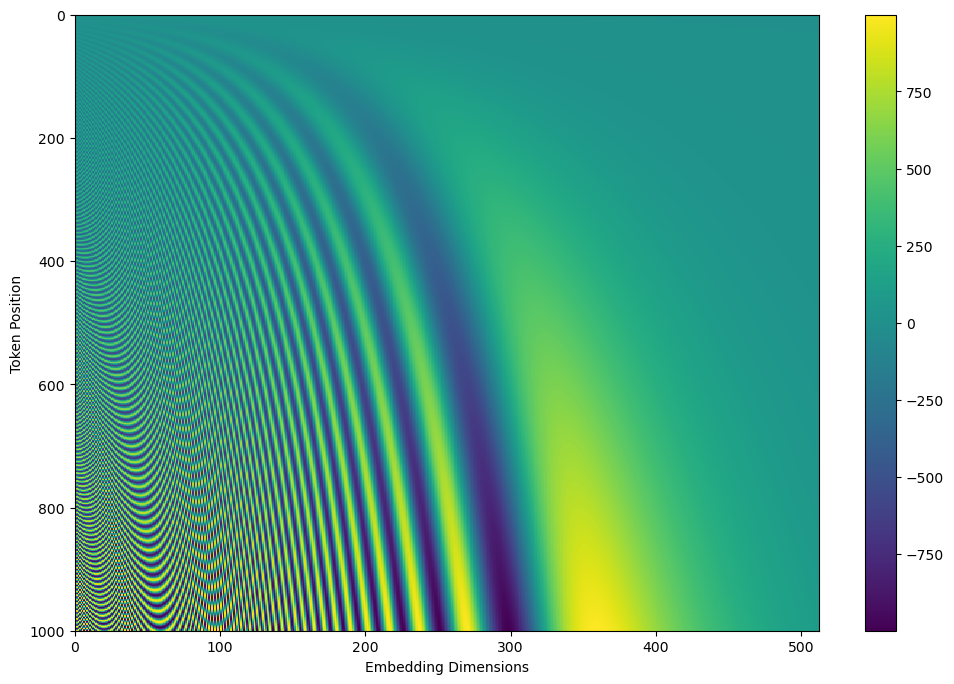

In [245]:
plt.figure(figsize=(12,8))
plt.pcolormesh(positions[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, 512))
plt.ylim((seq_len,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [254]:
class InputEmbedding(tf.keras.layers.Layer):
    
    def _init_(self,vocab_size,emb_size,input_length):
        
        super()._init_()
        
        self.emb_size = emb_size
        self.vocab_size= vocab_size
        
        self.input_emb = Embedding(
                        input_dim = self.vocab_size,
                        output_dim = self.emb_size,input_length = input_length
                                  )
        print('fsdaif')
    
    def _call_(self,x):
        print('yes')
        return  self.input_emb(x)

In [255]:


class PositionalEmbedding(tf.keras.layers.Layer):
    def _init_(self,batch_size,seq_len,emb_size):
        
        super().__init__()
        positions = np.arange(seq_len)[:,np.newaxis]
        depth = np.arange(emb_size)[np.newaxis, :]
        depth = (2*depth//2)/emb_size

        angle_rates = 1 / (10000**depth)

        angle_rads  = positions * angle_rates
        angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2] = np.sin(angle_rads[:,1::2])


        positions = positions * angle_rads
           
        self.pos = tf.constant(np.broadcast_to(positions,[batch_size,seq_len,emb_size]))
        
        
    def __call__(self):
        return self.pos

In [256]:
emb = InputEmbedding()
out = emb(src)
out.shape

TensorShape([2, 5])

In [257]:
emb

# Self  Attention

In [194]:
class MultiHeadAttention(tf.keras.Model):
    
    def __init__(self,emb_size,batch_size,heads,seq_len,mode='self'):
        super(MultiHeadAttention,self).__init__()
        
        
        """"
        Parameters:
                emb_size (int): Embedding size (e.g 512)
                batch_size (int): Batch Size
                heads (int): Number of heads (e.g 8)
                seq_len (int): Number of words in each sequence
                mode (str): self or mask -> attention
                
        Returns:
            Out (Tensor)
        
        """
        self.emb_size= emb_size
        self.heads = heads
        self.head_dim = emb_size//heads
        self.seq_len = seq_len
        self.batch_size = batch_size
        
        # Queries, Keys and Values Matrices Layers
        self.queries = tf.keras.layers.Dense(self.emb_size)
        self.keys = tf.keras.layers.Dense(self.emb_size)
        self.values = tf.keras.layers.Dense(self.emb_size)
        self.mode = mode
        
    
    def self_attenion(self,queries,keys,values):
       
        out = np.zeros([self.batch_size,self.heads,self.seq_len,self.head_dim])
        
        # apply attetion mechanism
        for b in range(self.batch_size):
            for h in range(self.heads):
                for i in range(self.seq_len):
                    # Calculating the scores by multiplying Query with key
                    scores = tf.keras.layers.Dot(axes=-1)([queries[b,h,i,:][tf.newaxis,:], keys[b,h,:,:][tf.newaxis,:]])
                   
                    # Normalize the scores
                    scores = scores/np.sqrt(self.head_dim)
                   
    #               apply Softmax
                    z = tf.keras.activations.softmax(scores[tf.newaxis,:],axis=1)
                    
                    
                    # Multiply the score with value vectors
                    value_vectors = tf.cast(tf.transpose(values[b,h,:,:]),dtype=tf.float32) * tf.cast(z,dtype=tf.float32)
                    
                    
                    out[b,h,i,:] = tf.reduce_sum(value_vectors,axis=-1)

        return tf.reshape(out,(self.batch_size,self.seq_len,self.emb_size))
    
    
    def mask_attention(self,queries,keys,values):
        
        out = np.zeros([self.batch_size,self.heads,self.seq_len,self.head_dim])
        
        # apply attetion mechanism
        for b in range(self.batch_size):
            for h in range(self.heads):
                for i in range(self.seq_len):
                    # Calculating the scores by multiplying Query with key
                    scores = tf.keras.layers.Dot(axes=-1)([queries[b,h,i,:][tf.newaxis,:], keys[b,h,:,:][tf.newaxis,:]]).numpy().reshape(5)
                    scores[i+1:] = -(np.inf)
                    
                    # Normalize the scores
                    scores = scores/np.sqrt(self.head_dim)
                   
    #               apply Softmax
                    z = tf.keras.activations.softmax(tf.constant(scores)[tf.newaxis,:],axis=1)
                    
                    
                    # Multiply the score with value vectors
                    value_vectors = tf.cast(tf.transpose(values[b,h,:,:]),dtype=tf.float32) * tf.cast(z,dtype=tf.float32)
                    
                    
                    out[b,h,i,:] = tf.reduce_sum(value_vectors,axis=-1)

        return tf.reshape(out,(self.batch_size,self.seq_len,self.emb_size))
    
    def __call__(self,x,enc_key=[],enc_value=[]):
        
        
        # As mention in the paper first we multiply each word embedding in our case 512 with 512x512 Matrcis
        # We pass our data through the dense layer
        
        # For Multiheaded Attention
        if len(enc_key)==0 and len(enc_value)==0:
            queries = self.queries(x)
            keys = self.keys(x)
            values = self.values(x)
            
        else:
            
            # Multi Headed when keys and values come from encoder part
            queries = self.queries(x)
            keys = self.keys(enc_key)
            values = self.values(enc_value)

        queries = tf.reshape(queries,[self.batch_size,self.heads,self.seq_len,self.head_dim])
        keys = tf.reshape(keys,[self.batch_size,self.heads,self.seq_len,self.head_dim])
        values = tf.reshape(values,[self.batch_size,self.heads,self.seq_len,self.head_dim])
        
          
        if self.mode == 'self':
            
            # Self Attention
            attention = self.self_attenion(queries,keys,values)
            
        # Apply masked multiheaded attention
        if self.mode == 'mask':
            attention = self.mask_attention(queries,keys,values)

            
        # Last matrix 
        
        out = tf.keras.layers.Dense(self.emb_size)(attention)
                          
        return out
    
    

In [195]:
x = np.random.rand(10,5,512)
mha = MultiHeadAttention(512,10,8,5,mode='mask')

out = mha(x)
out.shape

TensorShape([10, 5, 512])

# Encoder Block

In [196]:
class Encoder(tf.keras.Model):
    def __init__(self,
               emb_size=512,
               heads=8,
               forward_expansion=4):
    
        super(Encoder,self).__init__()

        self.emb_size = emb_size
        self.seq_len = x.shape[-2]
        self.batch_size = x.shape[0]
        self.heads = heads
        self.expansion_rate = forward_expansion

        self.mha = MultiHeadAttention(
                                  self.emb_size,
                                  self.batch_size,
                                  self.heads,self.seq_len
                                      )
        self.dense_1 = tf.keras.layers.Dense(int(self.emb_size*self.expansion_rate),activation='relu')
        self.dense_2 = tf.keras.layers.Dense(self.emb_size,activation='relu')

        self.layer_norm = tf.keras.layers.LayerNormalization()


    def __call__(self,x):

        self_attention = mha(x)

        x = tf.keras.layers.Add()([x,self_attention])

        x = self.layer_norm(x)

        dense = self.dense_1(x)
        dense = self.dense_2(dense)

        x = tf.keras.layers.Add()([dense,x])
        x = self.layer_norm(x)


        return x

In [197]:
inp = tf.keras.layers.Input(shape=(10,5,512))
inp2 =  tf.keras.layers.Input(shape=(10,5,512))

encoder = Encoder()
encoder(x).shape

TensorShape([10, 5, 512])

In [208]:
x.shape

(10, 5, 512)

# Decoder

In [212]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self,emb_size=512,
               heads=8,
               forward_expansion=4):
        
        
        super(Decoder,self).__init__()

        self.emb_size = emb_size
        self.seq_len = x.shape[-2]
        self.batch_size = x.shape[0]
        self.heads = heads
        self.expansion_rate = forward_expansion
        
        
        #Mask Multihead Attention
        self.causal_attention = MultiHeadAttention(self.emb_size,
                                                self.batch_size,
                                                self.heads,
                                                self.seq_len,
                                                mode = 'mask')
        
        # MultiHeaded Attention
        self.mha = MultiHeadAttention(self.emb_size,
                                      self.batch_size,
                                      self.heads,
                                      self.seq_len)
        
        
        self.dense_1 = tf.keras.layers.Dense(int(self.emb_size*self.expansion_rate),activation='relu')
        self.dense_2 = tf.keras.layers.Dense(self.emb_size,activation='relu')

        self.layer_norm = tf.keras.layers.LayerNormalization()
        
    def __call__(self,x,enc_key,enc_value):
        
       
        # Apply mask Attention
        mask_attention = self.causal_attention(x)
        
        x = tf.keras.layers.Add()([x,mask_attention])
        x = self.layer_norm(x)
        
        # Self Attention
        self_attention = self.mha(x,enc_key,enc_value)
        
        x = tf.keras.layers.Add()([x,self_attention])
        x = self.layer_norm(x)
        
        
        
        dense = self.dense_1(x)
        dense = self.dense_2(dense)
        
        x = tf.keras.layers.Add()([x,dense])
        x = self.layer_norm(x)
        
        return x
        

In [213]:
x = np.random.rand(10,5,512)
enc_key = np.random.rand(10,5,512)
enc_value = np.random.rand(10,5,512)
decoder = Decoder()
out = decoder(x,enc_key,enc_value)

out.shape

TensorShape([10, 5, 512])

# Transformer

In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_size=512,
                 heads=8,
                 expansion_rate=4,
                 num_modules=6,
                 batch_size = 8):
        
        
       
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.heads = heads
        self.expansion_rate = expansion_rate
        self.num_modules = num_modules
        self.batch_size = batch_size
        
        self.encoder_layers = [Encoder() for _ in range(num_modules)]
        
    
    
    def __call__(self,x):
        
        # input embeddings
        input_embeddings = InputEmbedding(vocab_size,emb_size,x.shape[-1])(x)
        
        #positional encoding
        
        positional_encodings = PositionalEmbedding(self.batch_size,x.shape[-1],self.emb_size)()
        
        
        
        
        
        
        
        

In [232]:
x = np.random.rand(2,5)
x.shape[-1]

5